# Questions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [ ]:
df1 = pd.read_json('/content/drive/MyDrive/LAOPO/mse?/updated_GPT2.json', encoding='utf-8', lines=True)
df2 = pd.read_json('/content/drive/MyDrive/LAOPO/mse?/final_NB.json', encoding='utf-8', lines=True)
df3 = pd.read_json('/content/drive/MyDrive/LAOPO/mse?/updated_logistic.json', encoding='utf-8', lines=True)
df4 = pd.read_csv('/content/drive/MyDrive/LAOPO/mse?/predictions.csv')

In [ ]:
len(df1), len(df2), len(df3), len(df4)

(100000, 100000, 100000, 100000)

In [ ]:
df1.rename(columns={'predict_value': 'predict_value_gpt2'}, inplace=True)
df3.rename(columns={'predict_value': 'predict_value_logistic'}, inplace=True)
df4.rename(columns={'predicted_class': 'predict_value_bertlstm'}, inplace=True)

In [ ]:
df1 = df1.sort_values(by='reviewText')
df2 = df2.sort_values(by='reviewText')
df3 = df3.sort_values(by='reviewText')
df4 = df4.sort_values(by='reviewText')

In [ ]:
df1['predict_value_logistic'] = df3['predict_value_logistic']
df1['predict_value_NB'] = df2['predict_value_NB']
df1['predict_value_bertlstm'] = df4['predict_value_bertlstm']

In [ ]:
tt_df = df1

In [ ]:
train_index = pd.read_csv('/content/drive/MyDrive/LAOPO/mse?/training_index.csv')

In [ ]:
tt_df = tt_df.reset_index()

In [ ]:
train_df = tt_df.merge(train_index, on=['index', 'class'], how='inner')
# df_merge = df_merge.reset_index()
# train_df = df_merge.merge(train_index, on=['index', 'class'], how='inner')

In [ ]:
len(train_df)

80000

In [ ]:
test_df = tt_df[tt_df['index'].isin(train_df['index']) == False]

# Weight Calculation Algorithm

$\operatorname{MSE}=\frac{1}{n} \sum_{i=1}^n\left(\text { class }_i-\text { combined_predictions }_i\right)^2$

## Minimize MSE through Model Weights

In [ ]:
predict_value_NB = np.array(train_df['predict_value_NB'].values.tolist())
predict_value_logistic = np.array(train_df['predict_value_logistic'].values.tolist())
predict_value_gpt2 = np.array(train_df['predict_value_gpt2'].values.tolist())
predict_value_bertlstm = np.array(train_df['predict_value_bertlstm'].values.tolist())
class_values = np.array(train_df['class'].values.tolist())

In [ ]:
def mse_loss(weights):
    # Ensure weights are normalized
    combined_predictions = (
        weights[0] * predict_value_NB +
        weights[1] * predict_value_logistic +
        weights[2] * predict_value_gpt2 +
        weights[3] * predict_value_bertlstm
    )
    return np.mean((class_values - combined_predictions) ** 2)

In [ ]:
# Initial weights (equal weights as a starting point)
initial_weights = [0.25, 0.25, 0.25, 0.25]

# Constraints: sum of weights = 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Bounds for each weight: between 0 and 1
bounds = [(0, 1) for _ in range(4)]

# Minimize the MSE loss
result = minimize(mse_loss, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP')

In [ ]:
optimal_weights = result.x
print("Optimal Weights:", optimal_weights)
print("Optimal Weights:", [round(w, 4) for w in optimal_weights])

Optimal Weights: [0.13163362 0.04004987 0.33150028 0.49681624]
Optimal Weights: [0.1316, 0.04, 0.3315, 0.4968]


In [ ]:
min_mse = result.fun
print("Minimum MSE:", min_mse)

Minimum MSE: 0.06469028047826848


The final weights are shown in the following:
* Naive Bayesian: 19.42%
* Logistic Regression: 2.25%
* GPT2: 3.46%
* BERT + LSTM: 74.87%

Here is the summary:
* Model Performance: BERT + LSTM is significantly outperforming the other models in terms of aligning its predictions with the true values (class). It has the largest weight because it minimizes the MSE the most.
* Model Importance: Naive Bayesian contributes a moderate amount, suggesting it provides useful information, though not as much as BERT + LSTM.
* Low Contribution Models: Logistic Regression and GPT-2 contribute very little, likely because their predictions are less correlated with the actual values or have higher errors. Maybe GPT-2 is not fine-tuned correctly.

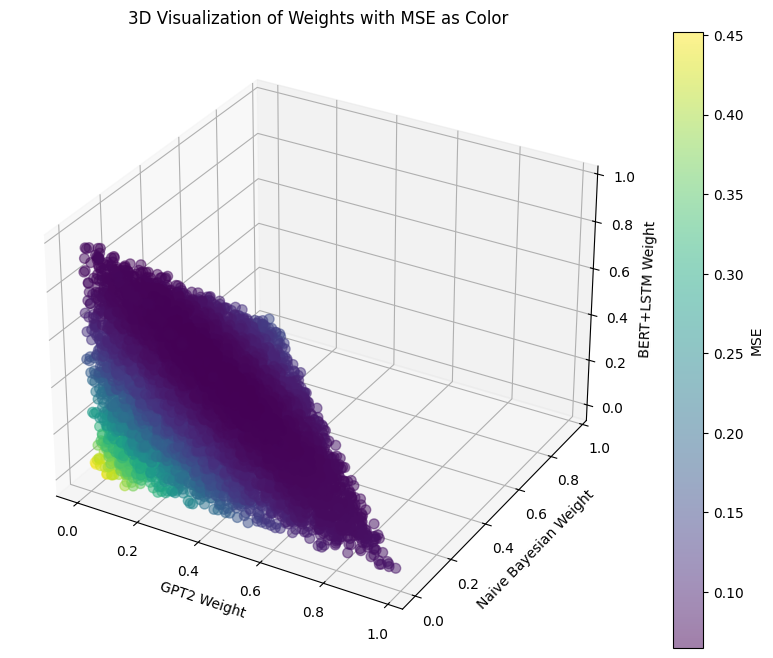

In [ ]:
# Define the MSE function
def mse_loss(weights):
    combined_predictions = (
        weights[0] * predict_value_NB +
        weights[1] * predict_value_logistic +
        weights[2] * predict_value_gpt2 +
        weights[3] * predict_value_bertlstm
    )
    return np.mean((class_values - combined_predictions) ** 2)

# Generate random weights ensuring the sum equals 1
n_points = 10000
weights = np.random.dirichlet(np.ones(4), size=n_points)  # Generates weights summing to 1

# Compute MSE for each weight combination
mse_values = np.array([mse_loss(w) for w in weights])

# Separate weights
w_NB, w_logistic, w_gpt2, w_bertlstm = weights.T

# 3D Scatter plot with MSE as color
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(w_gpt2, w_NB, w_bertlstm, c=mse_values, cmap='viridis', s=50, alpha=0.5)

# Add labels and color bar
ax.set_xlabel('GPT2 Weight')
ax.set_ylabel('Naive Bayesian Weight')
ax.set_zlabel('BERT+LSTM Weight')

cbar = fig.colorbar(scatter, ax=ax, label='MSE')
plt.title('3D Visualization of Weights with MSE as Color')
plt.show()

## Maximize Accuracy through Threshold

In [ ]:
train_df['predict_bagging'] = optimal_weights[0] * train_df['predict_value_NB'] + \
                              optimal_weights[1] * train_df['predict_value_logistic'] + \
                              optimal_weights[2] * train_df['predict_value_gpt2'] + \
                              optimal_weights[3] * train_df['predict_value_bertlstm']

In [ ]:
predict_bagging = np.array(train_df['predict_bagging'].values.tolist())

In [ ]:
thresholds = np.linspace(0, 1, num=100)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    predictions = (predict_bagging >= threshold).astype(int)  # Binary predictions
    return np.mean(predictions == class_values)  # Compare with true labels

# Compute accuracy for all thresholds
accuracies = [calculate_accuracy(th) for th in thresholds]

# Find the threshold with the highest accuracy
optimal_threshold = thresholds[np.argmax(accuracies)]
max_accuracy = max(accuracies)

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum Accuracy: {max_accuracy:.4f}")

Optimal Threshold: 0.5455
Maximum Accuracy: 0.9226


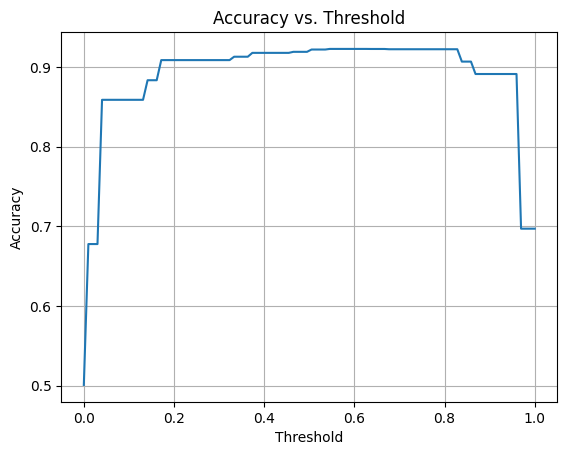

In [ ]:
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.grid(True)
plt.show()

Then we still choose 0.5455 as a reasonable threshold. The prediction accuracy is 92%.

# Test Dataset

In [ ]:
test_df = test_df.dropna()

In [ ]:
len(test_df)

20000

In [ ]:
test_df['predict_bagging'] = optimal_weights[0] * test_df['predict_value_NB'] + \
                             optimal_weights[1] * test_df['predict_value_logistic'] + \
                             optimal_weights[2] * test_df['predict_value_gpt2'] + \
                             optimal_weights[3] * test_df['predict_value_bertlstm']

In [ ]:
test_df['predict_bagging_binary'] = (test_df['predict_bagging'] > 0.5455).astype(int)

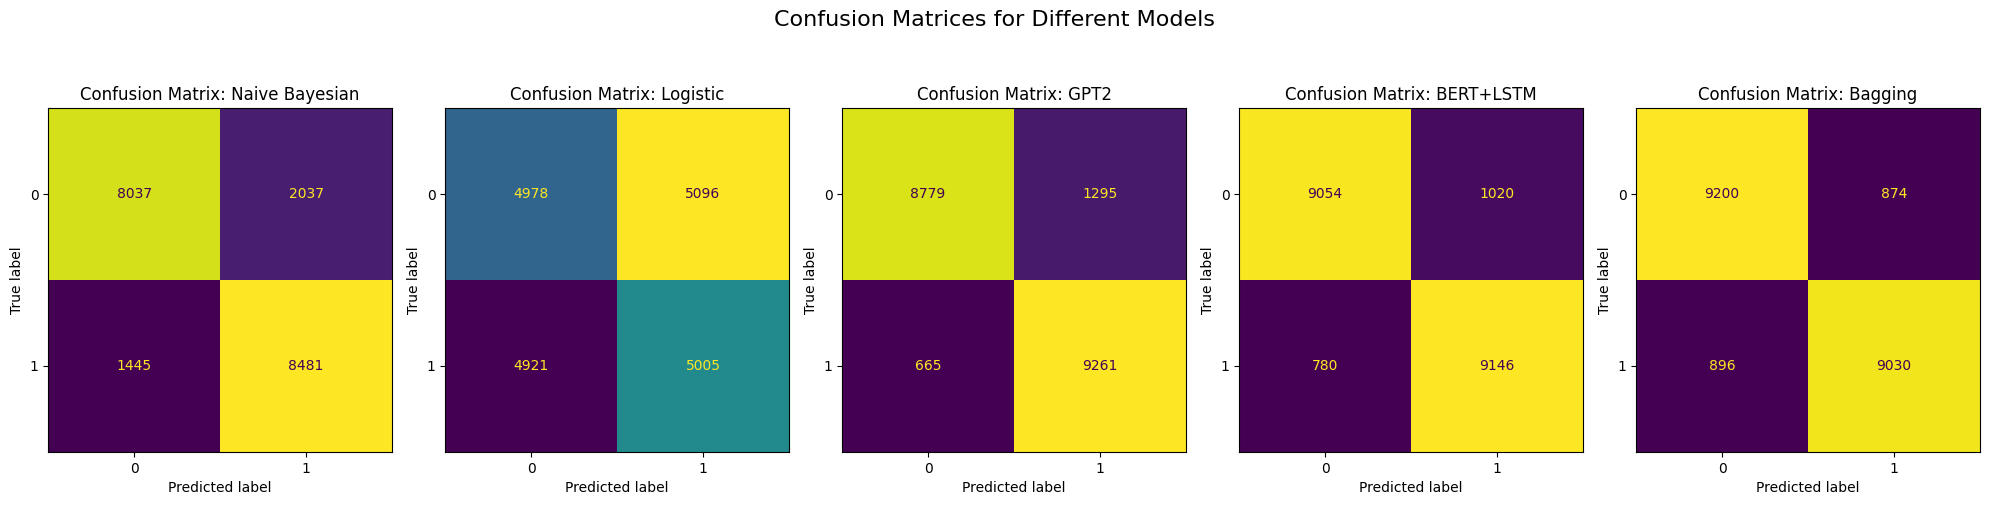

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5)) # Change axes, fig to fig, axes
prediction_columns =  ['predict_value_NB', 'predict_value_logistic', 'predict_value_gpt2', 'predict_value_bertlstm', 'predict_bagging_binary']
name =  ['Naive Bayesian', 'Logistic', 'GPT2', 'BERT+LSTM', 'Bagging']

# Loop through prediction columns and plot confusion matrices
for ax, col, n in zip(axes, prediction_columns, name):
    cm = confusion_matrix(test_df['class'], test_df[col])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='viridis', colorbar=False)
    ax.set_title(f"Confusion Matrix: {n}")

# Add a common title for the figure
plt.suptitle("Confusion Matrices for Different Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

In [ ]:
# Define prediction columns and model names
prediction_columns = ['predict_value_NB', 'predict_value_logistic', 'predict_value_gpt2', 'predict_value_bertlstm', 'predict_bagging_binary']
model_names = ['Naive Bayesian', 'Logistic', 'GPT2', 'BERT+LSTM', 'Bagging']

# Initialize results dictionary
results = {
    "Model": [],
    "True 0 Ratio": [],
    "True 1 Ratio": [],
    "Type I Error Ratio": [],
    "Type II Error Ratio": []
}

# Loop through each model's predictions and compute confusion matrix ratios
for col, name in zip(prediction_columns, model_names):
    cm = confusion_matrix(test_df['class'], test_df[col])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    # Calculate ratios
    true_0_ratio = tn / total
    true_1_ratio = tp / total
    type_I_error_ratio = fp / total
    type_II_error_ratio = fn / total

    # Append results
    results["Model"].append(name)
    results["True 0 Ratio"].append(true_0_ratio)
    results["True 1 Ratio"].append(true_1_ratio)
    results["Type I Error Ratio"].append(type_I_error_ratio)
    results["Type II Error Ratio"].append(type_II_error_ratio)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

In [ ]:
results_df

,Model,True 0 Ratio,True 1 Ratio,Type I Error Ratio,Type II Error Ratio
0,Naive Bayesian,0.40185,0.42405,0.10185,0.07225
1,Logistic,0.24890,0.25025,0.25480,0.24605
2,GPT2,0.43895,0.46305,0.06475,0.03325
3,BERT+LSTM,0.45270,0.45730,0.05100,0.03900
4,Bagging,0.46000,0.45150,0.04370,0.04480


In [ ]:
results_df['accuracy'] = (results_df['True 0 Ratio'] + results_df['True 1 Ratio'])
results_df['error'] = (results_df['Type I Error Ratio'] + results_df['Type II Error Ratio'])

In [ ]:
results_df

,Model,True 0 Ratio,True 1 Ratio,Type I Error Ratio,Type II Error Ratio,accuracy,error
0,Naive Bayesian,0.40185,0.42405,0.10185,0.07225,0.82590,0.17410
1,Logistic,0.24890,0.25025,0.25480,0.24605,0.49915,0.50085
2,GPT2,0.43895,0.46305,0.06475,0.03325,0.90200,0.09800
3,BERT+LSTM,0.45270,0.45730,0.05100,0.03900,0.91000,0.09000
4,Bagging,0.46000,0.45150,0.04370,0.04480,0.91150,0.08850


In [ ]:
printtrain_df[['category','reviewTextEdit','class']].sample(10)

,category,reviewTextEdit,class
16176,Sports_and_Outdoors,burn flash back light time ride bought light i...,0
809,Cell_Phones_and_Accessories,absolutley love thing problem servic provid kn...,1
53174,Toys_and_Games,music toy loudest annoy ear pierc nois heard y...,0
57139,Home_and_Kitchen,definit take chlorin tast water yet filter las...,0
78532,Toys_and_Games,crayon best daughter write bathtub small piec ...,0
50603,Clothing_Shoes_and_Jewelry,bottom slipper look thick pictur cushion good ...,0
76959,Toys_and_Games,year old love piano perfect size play play oft...,1
25169,Toys_and_Games,order year old granddaught birthday along matc...,1
41824,Cell_Phones_and_Accessories,husband want blue otterbox cover like last one...,1
69798,Toys_and_Games,wow suppos get christma eve fault thier lost u...,1


In [ ]:
test_df.sample(10)

,index,category,summary,reviewText,class,reviewTextEdit,text_length,predict_value_gpt2,predict_value_logistic,predict_value_NB,predict_value_bertlstm,predict_bagging,predict_bagging_binary
26100,60305,Sports_and_Outdoors,What a difference Petzel makes,I have used cheap headlamps for the past 10 ye...,1,use cheap headlamp past year never pleas last ...,432,1,1,1,1,1.00000,1
87723,95336,Toys_and_Games,Super Fun Game of Strategy and Chance,We are a gaming family. I was excited to see A...,1,game famili excit see asara ravensburg maker l...,1007,0,0,1,1,0.62845,1
91708,41868,Home_and_Kitchen,False advertisement!! Disappointed!!!,Works well just like any other but not the sam...,0,work well like product shown pictur disappoint...,68,0,0,0,0,0.00000,0
94255,98985,Toys_and_Games,didnt last very long,i bought this for a school project so i only n...,0,bought school project need day start problem j...,93,0,1,0,0,0.04005,0
27971,18248,Cell_Phones_and_Accessories,Had a good beginning,I liked this phone at the beginning but I have...,0,like phone begin year start freez slow sluggis...,208,0,0,0,0,0.00000,0
44035,43053,Home_and_Kitchen,It is pretty easy to assemble once you read th...,It is pretty easy to assemble once you read th...,1,pretti easi assembl read instruct plastic thin...,158,0,0,0,0,0.00000,0
45485,76761,Sports_and_Outdoors,It's fine,It's Bingo and all the kids love to play Bingo...,1,bingo kid love play bingo enough differ word l...,81,1,0,1,1,0.95995,1
63790,19530,Cell_Phones_and_Accessories,"Amazing Case, but no screen protector",The case is very good in quality and very dura...,1,case good qualiti durabl well went snowboard b...,224,1,1,1,1,1.00000,1
67140,88225,Toys_and_Games,Just similar to Curious George,The picture looks much better that the real to...,0,pictur look much better real toy see pictur mu...,108,0,0,0,0,0.00000,0
91561,11673,Cell_Phones_and_Accessories,Excellent product,"Works great, charges up both my ipad and iphon...",1,work great charg ipad iphon full get wallcharg,46,1,0,1,1,0.95995,1


In [ ]:
test_df.to_csv('/content/drive/MyDrive/LAOPO/mse?/test_df.csv', index=True)

In [ ]:
test_df.columns

Index(['index', 'category', 'summary', 'reviewText', 'class', 'reviewTextEdit',
       'text_length', 'predict_value_gpt2', 'predict_value_logistic',
       'predict_value_NB', 'predict_value_bertlstm', 'predict_bagging',
       'predict_bagging_binary'],
      dtype='object')

In [ ]:
temp = test_df[['reviewTextEdit','class','predict_value_gpt2','predict_value_logistic','predict_value_NB','predict_value_bertlstm','predict_bagging_binary']]
temp.sample(10)

,reviewTextEdit,class,predict_value_gpt2,predict_value_logistic,predict_value_NB,predict_value_bertlstm,predict_bagging_binary
67207,piec went togeth pretti easi stand seem sturdi...,0,0,1,0,0,0
49802,mess kept bay durabl nice cleaner crayon break...,1,1,0,0,1,1
17958,bought cash regist christma present son bit di...,0,0,1,0,0,0
87455,impress head explod even got bottom blown happ...,0,0,1,1,0,0
57503,phone drop head first ft high bathroom counter...,1,1,0,1,0,0
40172,huge kershaw fan unhappi finish knife sever ke...,0,0,1,1,0,0
46210,loud otherwis work well bluetooth synch quickl...,1,1,0,1,1,1
71268,bowl good noth heavi wish heavier rubber botto...,0,0,0,0,1,0
98623,excel product expect good qualiti afford price...,1,1,0,1,1,1
29482,love littl coffe brewer fit perfectli desk k c...,1,1,0,1,1,1
